In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import keras
from keras.models import Model, Sequential
from keras.layers import *
from keras.optimizers import Adam

import tensorflow as tf
import numpy as np

import pandas as pd
from collections import Counter
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [2]:
print(keras.__version__)
print(tf.__version__)

2.0.4
1.1.0


### Lets import our dataset

In [3]:
reviews = pd.read_csv('./imdb_data/reviews.txt', header=None)
labels = pd.read_csv('./imdb_data/labels_ohe.csv', header=None)

In [4]:
len(reviews)

25000

In [5]:
reviews.head()
reviews[0][4]

'brilliant over  acting by lesley ann warren . best dramatic hobo lady i have ever seen  and love scenes in clothes warehouse are second to none . the corn on face is a classic  as good as anything in blazing saddles . the take on lawyers is also superb . after being accused of being a turncoat  selling out his boss  and being dishonest the lawyer of pepto bolt shrugs indifferently  i  m a lawyer  he says . three funny words . jeffrey tambor  a favorite from the later larry sanders show  is fantastic here too as a mad millionaire who wants to crush the ghetto . his character is more malevolent than usual . the hospital scene  and the scene where the homeless invade a demolition site  are all  time classics . look for the legs scene and the two big diggers fighting  one bleeds  . this movie gets better each time i see it  which is quite often  .  '

In [6]:

labels[:5]
# 0 = bad 1 = good

,0,1
0,0.0,1.0
1,1.0,0.0
2,0.0,1.0
3,1.0,0.0
4,0.0,1.0


Counting the words in the dataset

In [7]:
total_counts = Counter()
for i,row in reviews.iterrows():
    total_counts.update(row[0].split(' '))

print("Total words in data set: ", len(total_counts))

Total words in data set:  74074


Just keeping the 10k most frequent words

In [13]:
vocab = sorted(total_counts, key=total_counts.get, reverse=True)[:10000]
print(vocab[40:50])

['like', 'there', 'her', 'or', 'just', 'about', 'out', 'if', 'has', 'what']


In [14]:
print(vocab[1], ': ', total_counts[vocab[1]])

the :  336713


### Making our word index table

we can input a word it gives back the number

In [15]:
word2idx = {word: i for i, word in enumerate(vocab)} #dictionary comprehension 

In [19]:
word2idx['good']

51

Convert the a review to a vector of words 10k long

In [20]:
def text_to_vector(text):
    word_vector = np.zeros(len(vocab), dtype=np.int_)
    for word in text.split(' '):
        idx = word2idx.get(word,None)
        if idx is None:
            continue
        else:
            word_vector[idx] = 1 # was += 1
    return np.array(word_vector)

In [21]:
text_to_vector('There were lots of good movies and stars this year')[:65]

array([0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [22]:
test_word_vector = text_to_vector('There were lots of good movies and stars this year')
test_word_vector.shape

(10000,)

Now do that for the whole corpus

In [23]:
word_vectors = np.zeros((len(reviews), len(vocab)), dtype=np.int_)
for ii, (_, text) in enumerate(reviews.iterrows()):
    word_vectors[ii] = text_to_vector(text[0])

In [24]:
# Printing out the first 3 word vectors
print(word_vectors[:3, :25])
print(reviews[:3])

[[1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 0 1 0 0 0 0 0 0 0 1]
 [1 1 1 1 1 1 1 1 0 1 0 0 0 1 1 0 0 1 1 0 0 0 1 1 0]
 [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 0 1 1 1 1 1]]
                                                   0
0  bromwell high is a cartoon comedy . it ran at ...
1  story of a man who has unnatural feelings for ...
2  homelessness  or houselessness as george carli...


Lets see what our tensor looks like

In [25]:
word_vectors.shape

(25000, 10000)

In [26]:

number_of_records = len(labels)
shuffle = np.arange(number_of_records)
np.random.shuffle(shuffle)
test_fraction = 0.8

#print(int(number_of_records*test_fraction))

#making a train / test split
train_split, test_split = shuffle[:int(number_of_records*test_fraction)], shuffle[int(number_of_records*test_fraction):]
x_train, y_train = word_vectors[train_split,:], labels.values[train_split,:]
x_test, y_test = word_vectors[test_split,:], labels.values[test_split]

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)
type(x_test[0][0])

(20000, 10000)
(20000, 2)
(5000, 10000)
(5000, 2)


numpy.int64

In [28]:
x_train, x_test, y_train, y_test = train_test_split(word_vectors,labels.values,test_size=0.2)

In [28]:
x_test[0].shape

(10000,)

In [29]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)
type(x_test[0][0])

(20000, 10000)
(20000, 2)
(5000, 10000)
(5000, 2)


numpy.int64

In [31]:
# Training Parameters for basic MNIST
learning_rate = 0.1 
training_epochs = 10
batch_size = 100

# Network Parameters
n_input = 10000 # MNIST data input (img shape: 28*28 flattened to be 784)
n_hidden_1 = 100 # 1st layer number of neurons
n_hidden_2 = 100 # 2nd layer number of neurons
n_hidden_3 = 100 # 2nd layer number of neurons
n_classes = 2 # MNIST classes for prediction(digits 0-9 )

In [32]:
Inp = Input(shape=(n_input,))
x = Dense(n_hidden_1, activation='relu', name = "Dense_1")(Inp)
x = Dropout(0.8)(x)
x = Dense(n_hidden_2, activation='relu', name = "Dense_2")(x)
x = Dropout(0.8)(x)
x = Dense(n_hidden_3, activation='relu', name = "Dense_3")(x)
x = Dropout(0.5)(x)
output = Dense(n_classes, activation='softmax', name = "Outputlayer")(x)


In [33]:
model = Model(Inp, output)

In [34]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 10000)             0         
_________________________________________________________________
Dense_1 (Dense)              (None, 100)               1000100   
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
Dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
Dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)               0         
__________

In [35]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['acc'])

In [36]:
history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=training_epochs,
                    verbose=1, # This is for what we want it to display out as it trains 
                    validation_data=(x_test, y_test))

Train on 20000 samples, validate on 5000 samples
Epoch 1/10
20000/20000 [==============================] - 6s - loss: 0.6869 - acc: 0.5523 - val_loss: 0.5935 - val_acc: 0.8120

In [37]:
def plot_train(hist):
    h = hist.history
    if 'acc' in h:
        meas='acc'
        loc='lower right'
    else:
        meas='loss'
        loc='upper right'
    plt.plot(hist.history[meas])
    plt.plot(hist.history['val_'+meas])
    plt.title('model '+meas)
    plt.ylabel(meas)
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc=loc)

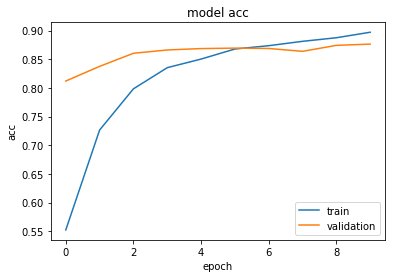

In [38]:
plot_train(history)

In [48]:
preds = model.predict(x_test[10:15])

In [49]:
preds

array([[ 0.8334921 ,  0.16650791],
       [ 0.13927421,  0.86072582],
       [ 0.2111524 ,  0.78884757],
       [ 0.12995026,  0.87004972],
       [ 0.07056675,  0.92943323]], dtype=float32)

In [50]:
y_test[10:15]

array([[ 1.,  0.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.],
       [ 0.,  1.]])

In [51]:
model.predict_on_batch(x_test[10:15])

array([[ 0.8334921 ,  0.16650791],
       [ 0.13927421,  0.86072582],
       [ 0.2111524 ,  0.78884757],
       [ 0.12995026,  0.87004972],
       [ 0.07056675,  0.92943323]], dtype=float32)